In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics

from sklearn.model_selection import train_test_split

%matplotlib inline

#sns.set(style='whitegrid', palette='muted', font_scale=1.5)

#rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
columns = ['x-axis', 'y-axis','z-axis','xg-axis', 'yg-axis','zg-axis','activity']
df=pd.read_csv("Act2_noise.csv",names=columns,skiprows=1)


In [3]:
df

,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis,activity
0,1.0000,2.0000,3.0000,4.0000,5.0000,6.0000,1
1,0.2811,0.1274,0.9778,-3.9024,-1.8293,4.2073,1
2,0.2809,0.1324,0.9744,-2.8659,-2.6829,3.8415,1
3,0.2870,0.1294,0.9727,-3.1707,-2.6829,3.7805,1
4,0.2906,0.1288,0.9706,-3.5976,-2.5000,3.9024,1
...,...,...,...,...,...,...,...
61143,-0.7471,-0.2786,0.5436,-7.0732,-9.2683,-17.9878,2
61144,-0.7456,-0.2745,0.5353,-2.3780,-6.2805,-14.5732,2
61145,-0.7316,-0.2733,0.5357,-2.9268,-6.5244,-11.5854,2
61146,-0.7307,-0.2755,0.5414,-2.6220,-7.9268,-9.7561,2


In [4]:
tf.__version__

'1.4.0'

In [5]:
df.shape

(61148, 7)

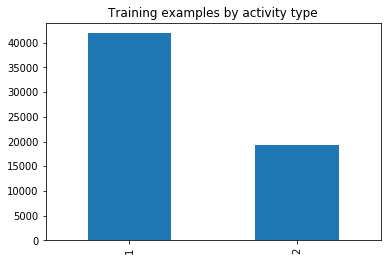

In [6]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [7]:
N_TIME_STEPS = 500
N_FEATURES = 6
step = 100
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    xsg = df['xg-axis'].values[i: i + N_TIME_STEPS]
    ysg = df['yg-axis'].values[i: i + N_TIME_STEPS]
    zsg = df['zg-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    #print label
    segments.append([xs, ys, zs, xsg, ysg, zsg])
    labels.append(label)
    #print labels

In [8]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [9]:
reshaped_segments.shape

(607, 500, 6)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [11]:
X_train.shape

(485, 500, 6)

In [12]:
X_test.shape

(122, 500, 6)

In [13]:
N_CLASSES = 2
N_HIDDEN_UNITS = 64

In [14]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden =tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [15]:
#tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [16]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [17]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [18]:
LEARNING_RATE = 0.00025
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [19]:
N_EPOCHS = 40
BATCH_SIZE = 128

In [20]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)
    #if i != 1 and i % 10 != 0:
        #continue

    print("epoch " + str(i) + ":  "+ "test accuracy:" + " " + str(acc_test) + " " + "loss:" + str(loss_test))
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

#print()
print("final results: accuracy:   " + str(acc_final) + "\t" +  "loss:  " +str(loss_final))

epoch 1:  test accuracy: 0.71311474 loss:1.3656485
epoch 2:  test accuracy: 0.7295082 loss:1.3438704
epoch 3:  test accuracy: 0.76229507 loss:1.3039823
epoch 4:  test accuracy: 0.6967213 loss:1.305629
epoch 5:  test accuracy: 0.704918 loss:1.297822
epoch 6:  test accuracy: 0.74590164 loss:1.2639537
epoch 7:  test accuracy: 0.74590164 loss:1.2460482
epoch 8:  test accuracy: 0.74590164 loss:1.225476
epoch 9:  test accuracy: 0.76229507 loss:1.2027843
epoch 10:  test accuracy: 0.7704918 loss:1.1796826
epoch 11:  test accuracy: 0.77868855 loss:1.17102
epoch 12:  test accuracy: 0.78688526 loss:1.1646957
epoch 13:  test accuracy: 0.795082 loss:1.1634171
epoch 14:  test accuracy: 0.8114754 loss:1.1645508
epoch 15:  test accuracy: 0.8196721 loss:1.1672497
epoch 16:  test accuracy: 0.8114754 loss:1.1663071
epoch 17:  test accuracy: 0.8278689 loss:1.159652
epoch 18:  test accuracy: 0.8360656 loss:1.1504942
epoch 19:  test accuracy: 0.8360656 loss:1.1433878
epoch 20:  test accuracy: 0.8360656 loss

In [21]:
pickle.dump(predictions, open("predictions_act2.p", "wb"))
pickle.dump(history, open("history_act2.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/activity_2.pbtxt')  
saver.save(sess, save_path = "./checkpoint/activity_2.ckpt")
sess.close()

In [22]:
history = pickle.load(open("history_act2.p", "rb"))
predictions = pickle.load(open("predictions_act2.p", "rb"))

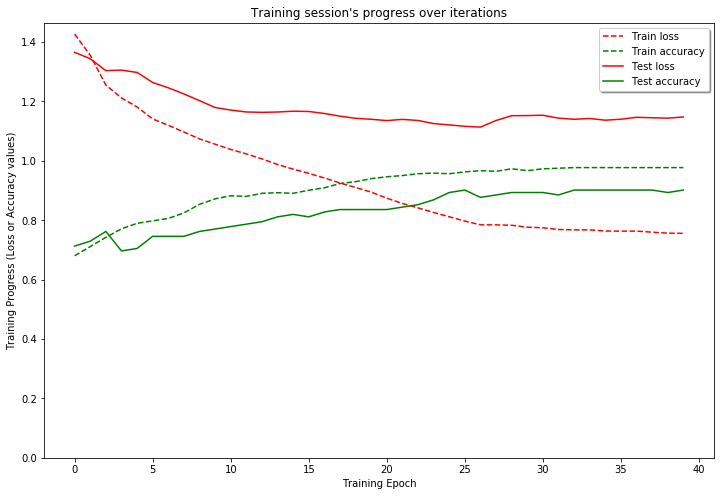

In [23]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [24]:
#activity
LABELS = [1,2]

In [25]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

In [26]:
#max_test = np.argmax(y_test, axis=1)
#ls = list(max_test)
#ls


In [27]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)

max_test1 = max_test.tolist()
print (max_test1)
print (len(max_test1))
max_predictions1 = max_predictions.tolist()
print(max_predictions1)
print(len(max_predictions1))

confusion_matrix(max_test1, max_predictions1)


[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]
122
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]
122


array([[84,  2],
       [10, 26]])

In [28]:
def data_reshaping(df):
    #df['activity'].value_counts().plot(kind='bar', title='Testing examples by activity type');
    N_TIME_STEPS = 500
    N_FEATURES = 6
    step = 100
    segments = []
    test_labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        xs = df['x-axis'].values[i: i + N_TIME_STEPS]
        ys = df['y-axis'].values[i: i + N_TIME_STEPS]
        zs = df['z-axis'].values[i: i + N_TIME_STEPS]
        xsg = df['xg-axis'].values[i: i + N_TIME_STEPS]
        ysg = df['yg-axis'].values[i: i + N_TIME_STEPS]
        zsg = df['zg-axis'].values[i: i + N_TIME_STEPS]
        
        label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
        segments.append([xs, ys, zs, xsg, ysg,zsg])
        test_labels.append(label)
    #print test_labels
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
    #test_labels = np.asarray(pd.get_dummies(test_labels), dtype = np.float32)
    #X_train, X_test, y_train, y_test = train_test_split(
        #reshaped_segments, test_labels, test_size=0.99, random_state=RANDOM_SEED)
    X_test = reshaped_segments
    y_test = test_labels
    
    #print test_labels
    return X_test, y_test
    

In [40]:
columns1=['ep','x-axis', 'y-axis' ,'z-axis' ,'xg-axis' ,'yg-axis' ,'zg-axis']
test = pd.read_csv('test_sub1.csv', header = None, names = columns1)
test

,ep,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis
0,1574837166040.0000,0.5126,-0.1758,0.6188,20.5488,-4.0854,18.7195
1,1574837166048.0000,0.4752,-0.1326,0.5773,14.2073,-10.3049,11.0366
2,1574837166063.0000,0.6762,-0.1224,0.5841,14.6951,-37.6220,10.4878
3,1574837166078.0000,0.8644,-0.1423,0.6310,14.3902,-63.2927,10.7927
4,1574837166079.0000,0.9518,-0.1674,0.6639,10.6098,-63.1707,11.2805
...,...,...,...,...,...,...,...
25356,1574837415970.0000,0.9486,-0.1805,0.1948,-1.0976,19.0244,-2.1951
25357,1574837415985.0000,0.9349,-0.1850,0.2339,-1.6463,22.4390,-2.7439
25358,Resetting devices,NaN,NaN,NaN,NaN,NaN,NaN
25359,Total Samples Received,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
test['activity']=1

In [42]:
test

,ep,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis,activity
0,1574837166040.0000,0.5126,-0.1758,0.6188,20.5488,-4.0854,18.7195,1
1,1574837166048.0000,0.4752,-0.1326,0.5773,14.2073,-10.3049,11.0366,1
2,1574837166063.0000,0.6762,-0.1224,0.5841,14.6951,-37.6220,10.4878,1
3,1574837166078.0000,0.8644,-0.1423,0.6310,14.3902,-63.2927,10.7927,1
4,1574837166079.0000,0.9518,-0.1674,0.6639,10.6098,-63.1707,11.2805,1
...,...,...,...,...,...,...,...,...
25356,1574837415970.0000,0.9486,-0.1805,0.1948,-1.0976,19.0244,-2.1951,1
25357,1574837415985.0000,0.9349,-0.1850,0.2339,-1.6463,22.4390,-2.7439,1
25358,Resetting devices,NaN,NaN,NaN,NaN,NaN,NaN,1
25359,Total Samples Received,NaN,NaN,NaN,NaN,NaN,NaN,1


In [43]:
x_test1, y_test1 = data_reshaping(test)

In [44]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver = tf.train.import_meta_graph("./checkpoint/activity_2.ckpt.meta")
    saver.restore(sess,tf.train.latest_checkpoint("./checkpoint"))
    predictions1= sess.run(pred_softmax, feed_dict={X: x_test1})
    #predictions, acc_final, loss_final = sess.run([pred_softmax, a, feed_dict={X: X_test1, Y: y_test1})
    sess.close()

INFO:tensorflow:Restoring parameters from ./checkpoint/activity_2.ckpt


In [45]:
y_ls = list(y_test1)
print(y_ls)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [46]:
max_predictions1 = np.argmax(predictions1, axis=1) + 1
print(len(list(max_predictions1)))
print((max_predictions1))

249
[2 2 1 1 1 1 1 2 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2 2 2 1 2 2 2 2 1 1 2 2
 2 1 1 2 2 2 2 2 2 2 2 2 2 1 1 1 2 2 2 2 2 1 1 2 1 2 2 1 2 1 2 2 2 1 2 2 1
 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1
 2 2 2 1 2 2 2 2 2 2 2 1 1 2 2 2 2 1 1 1 2 2 2 2 1 1 1 1 2 2 2 2 1 2 2 1 1
 1 1 2 2 2 1 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 1 1 2 2 2 2 2 2 2 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]


In [47]:
a=confusion_matrix(y_ls, max_predictions1)
print(a)
accuracy = ((a[0][1])*100)/(len(max_predictions1))
print(accuracy)

[[117 132]
 [  0   0]]
53.01204819277108
